# Preliminary Analysis (Figure 1)

Our hypothesis was that pairs of drugs that share the same indication have similar changes in gene expression. To do this, we compared two similarity metrics, spearman correlation and connectivity scores (created by the Broad Institute), between pairs of drugs that treated or did not treat the same indication.

## *1. Import the spearman correlations and connectivity scores for the DRH dataset*

In [1]:
# import data manipulation tool
import pandas as pd

In [2]:
### initialize a dictionary to store the DRH datasets
corrs = {}
### store a list of the cell lines used
cell_lines = ["A375", "MCF7", "PC3"]

### iterate through each cell line
for cell_line in cell_lines:
    ## store the DRH and datasets in their respective dictionaries
    file_path = "./DRH_clin_data/DRH_data/" + cell_line + "_unique_ind.txt"
    cell_line_corrs = pd.read_csv(file_path)
    ## store only the data with compounds with a high transcriptional response
    above_tas1 = cell_line_corrs["drug1 tas"] > 0.2
    above_tas2 = cell_line_corrs["drug2 tas"] > 0.2
    corrs[cell_line] = cell_line_corrs[above_tas1 & above_tas2]

corrs["MCF7"].head()

,drug1,drug1 tas,drug2,drug2 tas,spearman corr,indication,known ind
0,midostaurin,0.799386,altrenogest,0.812819,0.908978,Estrus,False
1,altrenogest,0.812819,midostaurin,0.799386,0.908978,"Leukemia, Myeloid, Acute",False
2,ixazomib-citrate,0.747696,ixazomib,0.791817,0.889649,Multiple Myeloma,True
3,ixazomib,0.791817,ixazomib-citrate,0.747696,0.889649,Multiple Myeloma,True
4,carfilzomib,0.763093,ixazomib-citrate,0.747696,0.839315,Multiple Myeloma,True


In [3]:
# read in the connectivity scores
file_path = "./conn_scores/conn_scores.txt"
cs = pd.read_csv(file_path)
cs.head()

,drug1,drug2,conn score
0,acyclovir,cabergoline,98.41
1,acyclovir,trimebutine,59.39
2,acyclovir,secnidazole,96.70
3,acyclovir,ipratropium,85.87
4,acyclovir,mestinon,96.12


## *2. Get the spearman correlations and connectivity scores on the same drug pairs*

In [4]:
### create a dictionary to resulting datasets
corrs_cs = {}
### define the list of columns to use from the spearman correlation dataset
cols = ["drug1", "drug2", "spearman corr", "indication", "known ind"]

### iterate through each cell line spearman correlation dataset
for cell_line, cell_line_corrs in corrs.items():
    ## store the spearman correlations and connectivity scores on the same set of drug pairs in dictionary
    corrs_cs[cell_line] = pd.merge(cell_line_corrs[cols], cs, on=["drug1", "drug2"], how="inner")

### show sample dataframe for MCF7 cell line
corrs_cs["MCF7"].head()

,drug1,drug2,spearman corr,indication,known ind,conn score
0,midostaurin,altrenogest,0.908978,Estrus,False,25.94
1,everolimus,sirolimus,0.777732,Lymphangioleiomyomatosis,False,84.28
2,paclitaxel,docetaxel,0.773948,Squamous Cell Carcinoma of Head and Neck,False,99.37
3,paclitaxel,docetaxel,0.773948,Prostatic Neoplasms,False,99.37
4,paclitaxel,docetaxel,0.773948,"Carcinoma, Non-Small-Cell Lung",True,99.37


## *3. Compare the spearman correlations and connectivity scores between pairs of drugs that do/do not treat the same indication*

In [5]:
# import the data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# import rank sum test
from scipy.stats import ranksums

In [6]:
# show the mean connectivity and spearman correlations between pairs of drugs that do/do not share the indication
corrs_cs["MCF7"].groupby("known ind").mean()

,spearman corr,conn score
known ind,,
False,0.190767,50.657275
True,0.356106,57.135617


### a. Perform rank sum test

In [7]:
### function to perform rank sum test for a cell line
def perform_ranksums(cell_line):
    ## store the data for that cell line
    cell_line_data = corrs_cs[cell_line]
    ## calculate the rank sums for spearman correlations between pairs of drugs that share or do not share indication
    share_ind = cell_line_data["known ind"]
    share_corrs = cell_line_data.loc[share_ind, "spearman corr"]
    no_share_corrs = cell_line_data.loc[~share_ind, "spearman corr"]
    corrs_stats, corrs_p_value = ranksums(no_share_corrs, share_corrs)
    
    ## calculate the rank sums for spearman correlations between pairs of drugs that share or do not share indication
    share_cs = cell_line_data.loc[share_ind, "conn score"]
    no_share_cs = cell_line_data.loc[~share_ind, "conn score"]
    cs_stats, cs_p_value = ranksums(no_share_cs, share_cs)
    
    ## summarize results in a dictionary
    results = {"cell line": cell_line,
               "spearman corr p-value": corrs_p_value,
               "conn score p-value": cs_p_value}
    return results

In [8]:
### create a dictionary to summarize rank sum p-values
ranksum_results = pd.DataFrame(columns=["cell line", "spearman corr p-value", "conn score p-value"])
### iterate through each cell line
for cell_line in cell_lines:
    ## get the p-values for cell line and store in dataframe
    results = perform_ranksums(cell_line)
    ranksum_results = ranksum_results.append(results, ignore_index=True)

### set index as the cell line
ranksum_results.set_index("cell line", inplace=True)
ranksum_results

,spearman corr p-value,conn score p-value
cell line,,
A375,7.833912e-34,0.000041
MCF7,2.065802e-23,0.004631
PC3,3.132552e-30,0.000003


### b. Generate figures

In [9]:
# set theme of figures
sns.set_style("whitegrid")

# set the font sizes of plots
plt.rcParams["axes.titlesize"] = 17 # title 
plt.rcParams["axes.labelsize"] = 15 # X and y axis labels
plt.rcParams["xtick.labelsize"] = 15  # X tick labels
plt.rcParams["ytick.labelsize"] = 15  # Y tick labels

In [10]:
### function to generate figure to compare spearman correlations and connectivity scores for one cell line
def compare_corrs_cs(cell_line):
    ## define the colors to separate between pairs of drugs that treat vs do not treat the same indication
    colors = [sns.color_palette("muted")[0], "#81df96"]
    ## create an empty figure with two subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

    ## create a violin plot comparing spearman correlation on left plot
    sns.violinplot(data=corrs_cs[cell_line],
                x = "known ind",
                y = "spearman corr",
                ax = ax1,
                palette = colors)
    
    ## add p-value from rank sum test
    corrs_p = ranksum_results.loc[cell_line, "spearman corr p-value"]
    ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1]+0.09) # adjust y-axis limits
    ax1.annotate('p = ' + format(corrs_p, ".2e"), xy=(0.5, 0.95), xycoords='axes fraction',
                 ha='center', va='center', fontsize=15, color='black')
    ## add lines around p-value
    y_pos = ax1.get_ylim()[1] * 0.915
    ax1.axhline(y=y_pos, xmin=0.26, xmax=0.39,
                color='black', linestyle='-', linewidth=2)
    ax1.axhline(y=y_pos, xmin=0.61, xmax=0.74,
                color='black', linestyle='-', linewidth=2)
    
    ## add labels to left plot
    ax1.set_title("Spearman Correlation Between Pairs of Drugs (" + cell_line + " cell line)")
    ax1.set_xlabel("")
    ax1.set_xticks([0,1])
    ax1.set_xticklabels(["Do Not Share Indication", "Share Indication"])
    ax1.set_ylabel("Spearman Correlation")
    
    ## create a violin plot comparing connectivity scores on right plot
    sns.violinplot(data=corrs_cs[cell_line],
                x = "known ind",
                y = "conn score",
                ax = ax2,
                palette = colors)
    
    ## add p-value from rank sum test
    cs_p = ranksum_results.loc[cell_line, "conn score p-value"]
    ax2.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1]+10) # adjust y-axis limits
    ax2.annotate('p = ' + format(cs_p, ".2e"), xy=(0.5, 0.96), xycoords='axes fraction',
                 ha='center', va='center', fontsize=15, color='black')
    
    ## add lines around p-value
    y_pos = ax2.get_ylim()[1] * 0.92
    ax2.axhline(y=y_pos, xmin=0.26, xmax=0.39,
                color='black', linestyle='-', linewidth=2)
    ax2.axhline(y=y_pos, xmin=0.61, xmax=0.74,
                color='black', linestyle='-', linewidth=2)

    ## add labels to right plot
    ax2.set_title("Connectivity Scores Between Pairs of Drugs")
    ax2.set_xlabel("")
    ax2.set_xticks([0,1])
    ax2.set_xticklabels(["Do Not Share Indication", "Share Indication"])
    ax2.set_ylabel("Connectivity Score")
    
    ## show plot
    plt.show()

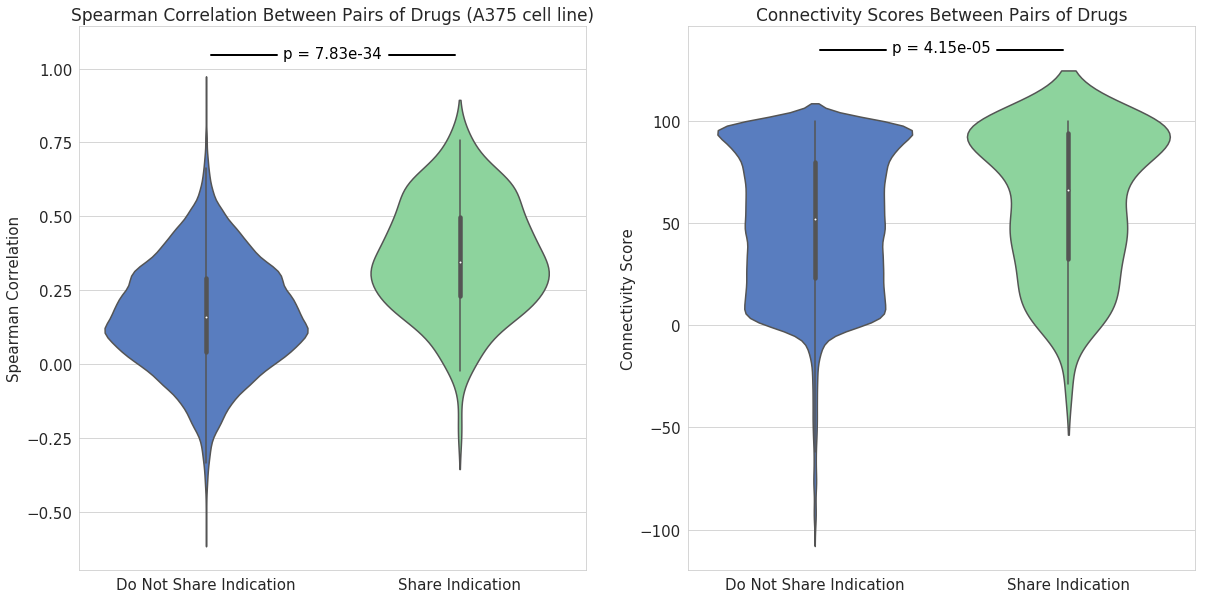

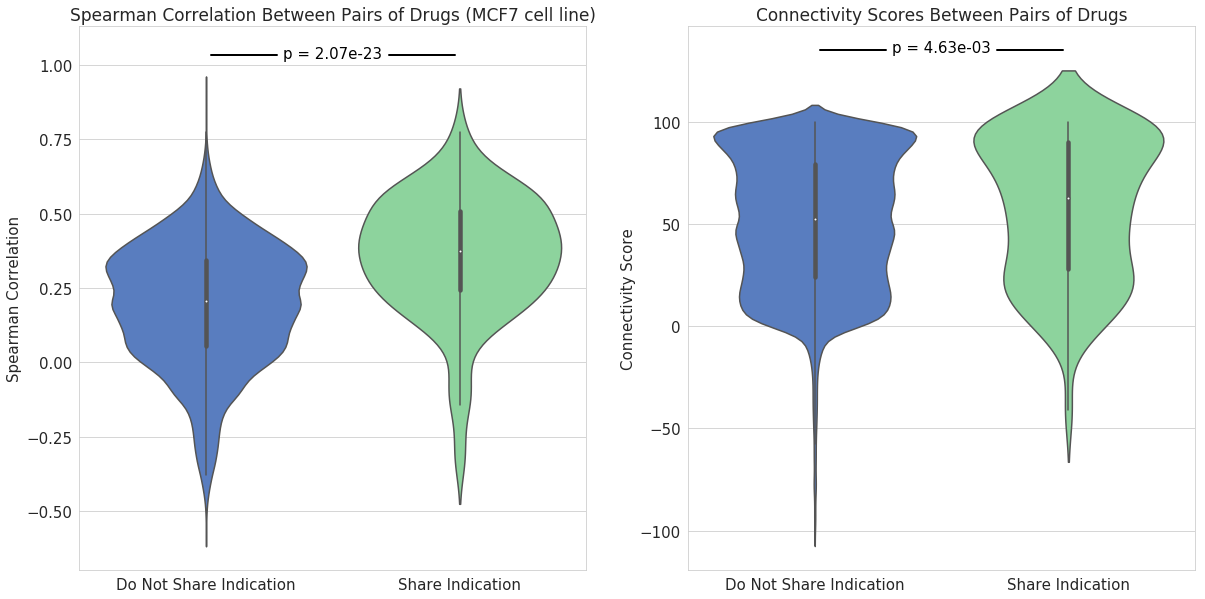

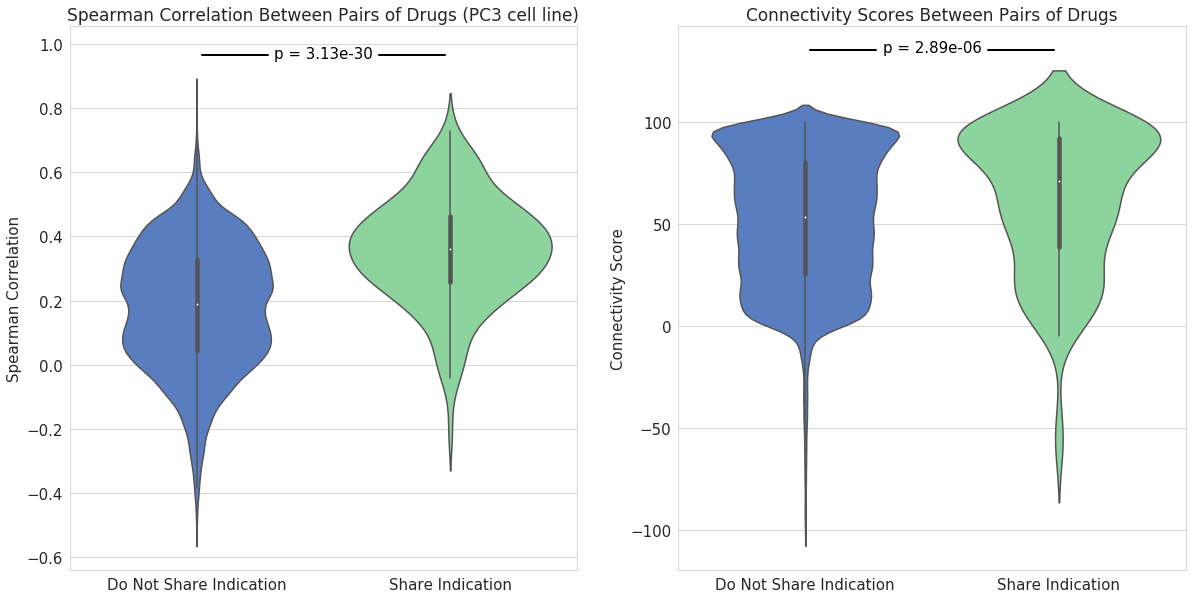

In [11]:
### iterate through each line
for cell_line in cell_lines:
    ## generate figure comparing spearman correlations and connectivity scores for that cell line
    compare_corrs_cs(cell_line)
    print("\n")